In [1]:
import json
import pathlib
import pickle
import re

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

import humanize

import numpy as np
import pandas as pd
import tensorflow as tf
from absl import app
from absl import flags
from absl import logging
from graph_nets.demos import models as gn_models
from graph_nets import utils_np as graph_net_utils_np

from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8 import prof
from labm8 import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read experimental data

Run training with:

```sh
rm -rf /tmp/phd/docs/wip_graph/train_model && bazel run //docs/wip_graph/notebooks:04_train_model -- --v=1 --df=/var/phd/shared/docs/wip_graph/lda_opencl_device_mapping_dataset.pkl --outdir=/tmp/phd/docs/wip_graph/train_model --num_epochs=2 --experimental_force_num_processing_steps=10 --experimental_maximum_split_count=2
```

Use tensorboard with:

```sh
python -m tensorboard.main --logdir='/tmp/phd/docs/wip_graph/train_model/tensorboard'
```

In [46]:
OUTDIR = pathlib.Path('/var/phd/shared/docs/wip_graph/models/opencl_devmap/graph/amd')
!ls {OUTDIR}

outputs.pkl  telemetry	tensorboard  test_outputs  values


In [47]:
def ReadTelemetryFiles(outdir: pathlib.Path):
    logs = []
    for json_file in (outdir / 'telemetry').iterdir():
        with open(json_file) as f:
            log = json.load(f)
        logs.append(log)
        log['training_loss'] = sum(log['training_losses']) / len(log['training_losses'])
    return pd.DataFrame(logs).sort_values(by=['epoch',])

df = ReadTelemetryFiles(OUTDIR)
df['group'] = 'Reachability'
df

,batch_runtime_ms,batch_size,epoch,initial_learning_rate,learning_rate,learning_rate_exponential_decay,num_processing_steps,test_accuracy,test_graph_count,test_graphs_per_second,...,training_loss,training_losses,training_solved,validation_accuracy,validation_graph_count,validation_graphs_per_second,validation_loss,validation_runtime_ms,validation_solved,group
3,"[40003, 9305, 6154, 7102, 7923, 9252, 2901]",64,1,0.001,1.000000e+00,0.99,50,0.414286,70,23.196348,...,16.733779,"[0.769873857498169, 9.094610214233398, 37.1544...",0.519608,0.410891,202,20.248763,6.329631,9975.918055,0.410891,Reachability
6,"[11264, 6771, 7999, 8317, 9077, 8339, 2517]",64,2,0.001,9.900000e-04,0.99,50,0.414286,70,23.093150,...,6.571350,"[6.936575889587402, 6.0733537673950195, 6.2398...",0.411765,0.410891,202,30.931777,6.196581,6530.500889,0.410891,Reachability
42,"[9462, 7547, 7802, 7107, 11792, 9276, 1726]",64,3,0.001,9.801000e-07,0.99,50,0.414286,70,23.251865,...,6.507734,"[6.960563659667969, 6.790693759918213, 5.77206...",0.411765,0.410891,202,31.201482,6.196282,6474.051476,0.410891,Reachability
1,"[9246, 9410, 5900, 5782, 9188, 9122, 4798]",64,4,0.001,9.702990e-10,0.99,50,0.414286,70,23.213179,...,6.426696,"[6.620720863342285, 6.620718479156494, 6.28115...",0.411765,0.410891,202,27.538298,6.196282,7335.239172,0.410891,Reachability
23,"[9112, 9562, 9221, 6561, 8651, 8513, 2422]",64,5,0.001,9.605960e-13,0.99,50,0.414286,70,23.180686,...,6.062922,"[6.451047897338867, 6.62074089050293, 7.299800...",0.411765,0.410891,202,30.978214,6.196282,6520.711660,0.410891,Reachability
31,"[9139, 8901, 8187, 7325, 10242, 7942, 3001]",64,6,0.001,9.509900e-16,0.99,50,0.414286,70,23.318649,...,6.426708,"[6.790500640869141, 6.281270980834961, 5.77196...",0.411765,0.410891,202,31.103405,6.196282,6494.465828,0.410891,Reachability
12,"[6270, 9850, 7292, 7711, 9569, 9948, 3093]",64,7,0.001,9.414801e-19,0.99,50,0.414286,70,23.373004,...,6.265032,"[6.281069755554199, 6.790622711181641, 5.94155...",0.411765,0.410891,202,27.474866,6.196282,7352.174282,0.410891,Reachability
35,"[8056, 6748, 8308, 9741, 9771, 7932, 3247]",64,8,0.001,9.320653e-22,0.99,50,0.414286,70,23.335922,...,6.386292,"[6.790443420410156, 5.771825790405273, 6.28112...",0.411765,0.410891,202,31.235021,6.196282,6467.099905,0.410891,Reachability
14,"[9009, 7890, 9129, 9091, 8016, 6376, 4103]",64,9,0.001,9.227447e-25,0.99,50,0.414286,70,23.102380,...,6.386276,"[6.111370086669922, 5.94160270690918, 6.281269...",0.411765,0.410891,202,30.809419,6.196282,6556.436539,0.410891,Reachability
4,"[7235, 9343, 8344, 9333, 5336, 11511, 2859]",64,10,0.001,9.135172e-28,0.99,50,0.414286,70,23.297521,...,6.386269,"[5.432429313659668, 6.451043128967285, 6.79053...",0.411765,0.410891,202,27.614221,6.196282,7315.071344,0.410891,Reachability


## Learning rate

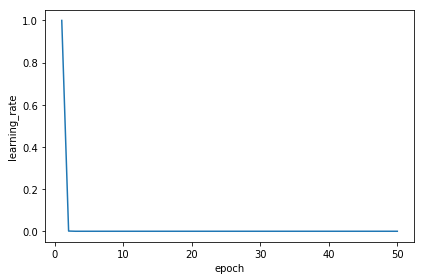

In [48]:
plt.plot(df.epoch, df.learning_rate)
plt.xlabel('epoch')
plt.ylabel('learning_rate')
viz.finalise()

### Loss

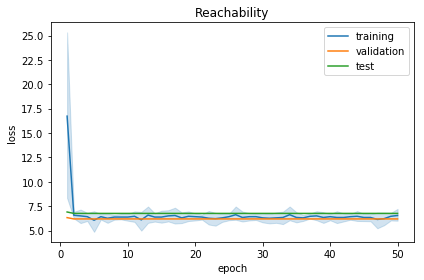

In [49]:
def TableOfAllTrainingLosses(df: pd.DataFrame):
    losses = []
    for _, row in df.iterrows():
        for loss in row['training_losses']:
            losses.append({
                'epoch': row['epoch'],
                'group': row['group'],
                'loss': loss,
            })
    return pd.DataFrame(losses)

groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'loss', data=TableOfAllTrainingLosses(df_to_plot), label='training')
    sns.lineplot('epoch', 'validation_loss', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_loss', data=df_to_plot, label='test')
    plt.ylabel('loss')
    plt.legend()
    plt.title(group)
    viz.finalise()

### Accuracy

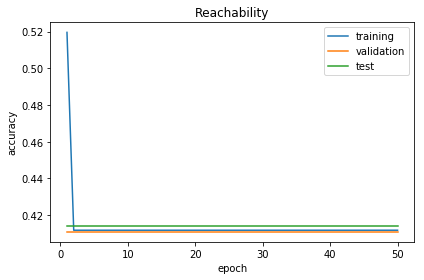

In [77]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'training_accuracy', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_accuracy', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_accuracy', data=df_to_plot, label='test')
    plt.ylabel('accuracy')
    plt.title(group)
    viz.finalise()

## Solved

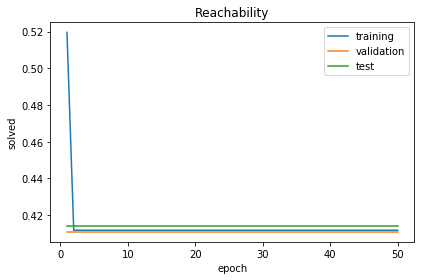

In [78]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'training_solved', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_solved', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_solved', data=df_to_plot, label='test')
    plt.ylabel('solved')
    plt.title(group)
    viz.finalise()

In [88]:
# Epoch with highest accuracy on the validation set.
best_result = df.iloc[df['validation_accuracy'].idxmax()]
print(f"best validation accuracy at epoch {best_result['epoch']}, accuracy: {best_result['test_accuracy']:.3%}, solved: {best_result['test_solved']:.3%}")
best_result

best validation accuracy at epoch 4, accuracy: 41.429%, solved: 41.429%


batch_runtime_ms                          [9246, 9410, 5900, 5782, 9188, 9122, 4798]
batch_size                                                                        64
epoch                                                                              4
initial_learning_rate                                                          0.001
learning_rate                                                            9.70299e-10
learning_rate_exponential_decay                                                 0.99
num_processing_steps                                                              50
test_accuracy                                                               0.414286
test_graph_count                                                                  70
test_graphs_per_second                                                       23.2132
test_loss                                                                    6.76207
test_runtime_ms                                                  